In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

## Distributions

In [2]:
# Birthday party problem
ns, ps = [], []
for n in range(2, 50):
    ns.append(n)
    ps.append(math.factorial(365) / math.factorial(365 - n) / 365**n)

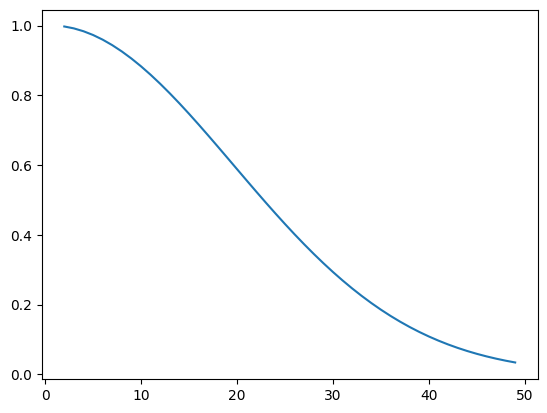

In [3]:
plt.plot(ns, ps)

In [6]:
list(zip(ns, ps))[20:22]

[(22, 0.5243046923374499), (23, 0.4927027656760146)]

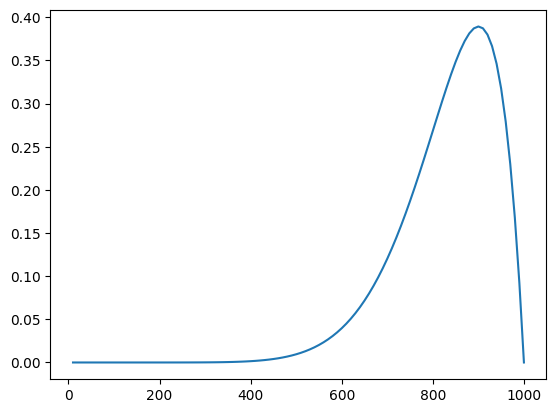

In [4]:
# Multinomial distr
N = 1000

n = 10
g = 9
b = n - g

granularity = 100
GG, pp = [], []
for i in range(1, granularity+1):
    G = int(N * i/granularity)
    GG.append(G)
    B = N - G
    pp.append(math.comb(G, g) * math.comb(B, b) / math.comb(N, n))

plt.plot(GG, pp)


## Hypothesis Testing

In [5]:
calls_per_day = 50
n_days = 60  # ~ 3mo
N = int(n_days * calls_per_day / 2)  # call in each group
historical_conversion = 0.01
n_success_A = int(N * historical_conversion)
desired_impove = 0.75
desired_conversion = historical_conversion * (1 + desired_impove)
n_success_B = int(N * desired_conversion)

print(f"historical_conversion={historical_conversion}, desired_conversion={desired_conversion}")
print(f"n_days={n_days}, N(each group)={N}, n_success_A={n_success_A}, n_success_B={n_success_B}")

historical_conversion=0.01, desired_conversion=0.0175
n_days=60, N(each group)=1500, n_success_A=15, n_success_B=26


In [6]:
# Null hypothesis: B is not effective
# => 
n_success_total = n_success_A + n_success_B
# => same distribution: binomial(n_success_total, p=0.5)

# Check prob that n_success_B ~ binomial(n_success_total, p=0.5)
n, k = n_success_total, n_success_B
p = 0.5

# print(f"prob that n_success_B ~ binomial(n_success_total, p=0.5) = {math.comb(n, k)*p**k*(1-p)**(n-k)}")
# binom.pmf(k, n, p)

In [7]:
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
mean, var

(np.float64(20.5), np.float64(10.25))

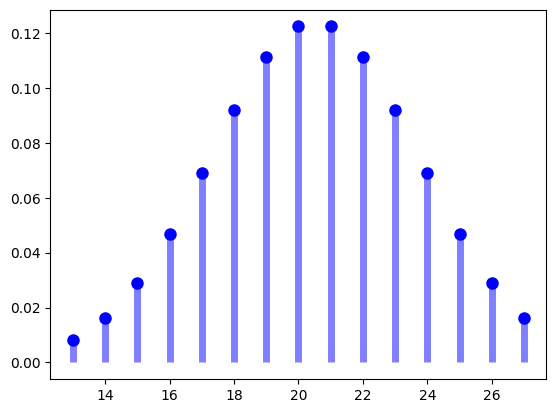

In [8]:
fig, ax = plt.subplots(1, 1)

x = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

In [9]:
# binom.cdf(x, n, p)

In [10]:
mean, var

(np.float64(20.5), np.float64(10.25))

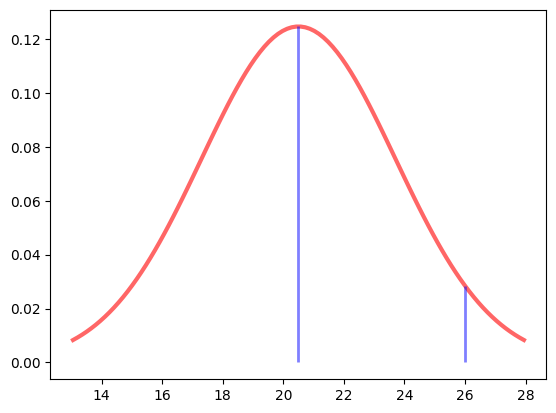

In [11]:
rv = norm(loc=mean, scale=math.sqrt(var))

fig, ax = plt.subplots(1, 1)
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)
ax.plot(x, rv.pdf(x),
       'r-', lw=3, alpha=0.6)
ax.vlines(mean, 0, rv.pdf(mean), colors='b', lw=2, alpha=0.5)
ax.vlines(k, 0, rv.pdf(k), colors='b', lw=2, alpha=0.5)

In [12]:
z_score = (k - mean) / math.sqrt(var)
z_score

np.float64(1.7179113807746667)

In [13]:
# one-sided
p_value = 1 - norm(loc=0, scale=1).cdf(z_score)
p_value

np.float64(0.0429063903252761)

In [14]:
conf_int = (k - 1.96 * math.sqrt(var), k + 1.96 * math.sqrt(var))
conf_int

(19.72493824731581, 32.275061752684195)

In [15]:
conf_int_improve = (conf_int[0] - float(mean), conf_int[1] - float(mean))
conf_int_improve

(-0.7750617526841914, 11.775061752684195)

In [16]:
conf_int_conversion_improve = (conf_int_improve[0] / mean, conf_int_improve[1] / mean)
conf_int_conversion_improve
# => conversion will increase + % (from historical convertion)

(np.float64(-0.03780789037483861), np.float64(0.5743932562284974))

In [17]:
# new conersion range:
(1 + conf_int_conversion_improve[0]) * historical_conversion, (1 + conf_int_conversion_improve[1]) * historical_conversion

(np.float64(0.009621921096251615), np.float64(0.015743932562284974))

## Hypothesis testing

In [189]:
# Data
group_a = np.array([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1])
group_b = np.array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [190]:
# Observed difference in conversion rates
obs_diff = group_a.mean() - group_b.mean()
obs_diff


np.float64(0.41666666666666663)

In [191]:
# Bootstrapping
n_iterations = 100_000
diffs = []

for _ in range(n_iterations):
    # Resample with replacement
    resample_a = np.random.choice(group_a, size=len(group_a), replace=True)
    resample_b = np.random.choice(group_b, size=len(group_b), replace=True)
    
    # Compute the difference in means
    diffs.append(resample_a.mean() - resample_b.mean())

# Convert to a numpy array for analysis
diffs = np.array(diffs)

In [192]:
diffs

array([0.25      , 0.66666667, 0.25      , ..., 0.5       , 0.16666667,
       0.5       ])

In [193]:
diffs.mean(), diffs.std()

(np.float64(0.41597000000000006), np.float64(0.18490143978166673))

In [194]:
# p-value: Proportion of bootstrap_diff <= 0
p_value = np.mean(diffs <= 0)

# Confidence interval (2.5th to 97.5th percentiles)
ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])

In [196]:
# Print results
print(f"Observed Difference: {obs_diff:.3f}")
print(f"p-value: {p_value:.3f}")
print(f"95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")

Observed Difference: 0.417
p-value: 0.025
95% Confidence Interval: [0.083, 0.750]


In [285]:
def two_tailed_p_value(n, k, p):
    """
    Calculate two-tailed p-value for a binomial test.
    
    Parameters:
    n: int - Number of tosses.
    k: int - Observed heads.
    p: float - Hypothesized probability of heads.
    
    Returns:
    float - Two-tailed p-value.
    """

    if k < n * p:
        p_value = 2 * binom.cdf(k, n, p)
    else:
        p_value = 2 * binom.sf(k, n, p)

    return p_value

In [286]:
def two_tailed_binomial_test(n, k, p, alpha=0.05):
    """
    For binomial test, decide whether ro reject the Null Hypothesis.
    
    Parameters:
    n: int - Number of tosses.
    k: int - Observed heads.
    p: float - Hypothesized probability of heads.
    
    Returns:
    bool - whether Null Hypothesis is rejected
    """

    return k <= binom.ppf(alpha/2, n, p) or binom.isf(alpha/2, n, p) <= k

In [287]:
n = 15  # Number of tosses
k = 10  # Observed heads
p_null = 0.5  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.5): 0.11846923828124999, H0 is rejected: False


In [289]:
n = 15  # Number of tosses
k = 11  # Observed heads
p_null = 0.5  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.5): 0.03515625, H0 is rejected: True


In [290]:
n = 15  # Number of tosses
k = 5  # Observed heads
p_null = 0.5  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.5): 0.30175781249999994, H0 is rejected: False


In [291]:
n = 15  # Number of tosses
k = 4 # Observed heads
p_null = 0.5  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.5): 0.11846923828124999, H0 is rejected: True


In [295]:
binom.ppf(0.025, n, p_null), binom.isf(0.025, n, p_null), binom.cdf(k, n, p_null)

(np.float64(4.0), np.float64(11.0), np.float64(0.017578125))

In [296]:
n = 15  # Number of tosses
k = 3 # Observed heads
p_null = 0.5  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.5): 0.03515625, H0 is rejected: True


In [297]:
binom.ppf(0.025, n, p_null), binom.isf(0.025, n, p_null), binom.cdf(k, n, p_null)

(np.float64(4.0), np.float64(11.0), np.float64(0.017578125))

In [298]:
n = 15  # Number of tosses
k = 7 # Observed heads
p_null = 0.2  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.2): 0.008479499419648014, H0 is rejected: True


In [300]:
binom.ppf(0.025, n, p_null), binom.isf(0.025, n, p_null), binom.sf(k, n, p_null)

(np.float64(0.0), np.float64(6.0), np.float64(0.004239749709824007))

In [301]:
n = 15  # Number of tosses
k = 1 # Observed heads
p_null = 0.2  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.2): 0.3342515348439046, H0 is rejected: False


In [302]:
n = 15  # Number of tosses
k = 1 # Observed heads
p_null = 0.8  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.8): 3.997695999999986e-09, H0 is rejected: True


In [303]:
n = 15  # Number of tosses
k = 6 # Observed heads
p_null = 0.8  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.8): 0.0015699707822079971, H0 is rejected: True


In [305]:
n = 15  # Number of tosses
k = 8 # Observed heads
p_null = 0.8  # Hypothesized probability

p_value = two_tailed_p_value(n, k, p_null)
reject_null = two_tailed_binomial_test(n, k, p_null)
print(f"p-value (H0: p={p_null}): {p_value}, H0 is rejected: {reject_null}")

p-value (H0: p=0.8): 0.03611761396940795, H0 is rejected: True
